<h2> Transforming a graph to node features in Graphomaly. Part 3/3 </h2>

We discuss now label transformations and explicit evaluation of anomaly detection.
The structure of this notebook is like in part 2, but now set the labels.
The new instructions are marked with *NEW*.

We start by reading the graph and remember that the last column of the dataframe contains the edge labels (1 for anomaly,
0 for normal).

In [1]:
import pandas as pd
import numpy as np

graph_file_name = "G1.csv"  # let's say that the file is in the current directory
G = pd.read_csv(graph_file_name)  # read graph as dataframe
G = G.to_numpy()     # convert to numpy array
y = G[:,4]           # last column of G contains edge labels

Besides the egonet and random walk base features, we will save the node labels in a file.
This is because the labels are transformed during the egonet calculations and so this is the cheapest solution.

In [2]:
# base features file names
ego_base_features_file_name = "G1_ego_base_features.csv"
rwalk_base_features_file_name = "G1_rwalk_base_features.csv"
# NEW: labels file name
labels_file_name = "G1_labels.csv"

There is no change in the parameters.

In [3]:
type = "graph_to_features"  # this is the transformation we want
egonet_args = {             # egonet parameters
    "ctor_args": {
        "verbose": True,    # to see something during the computation
    },
    "fit_args": {
        "feature_list": [   # this feature list is just an example, not necessarily the best
            "f_degree_in",
            "f_degree_out",
            "f_amount_in",
            "f_amount_out",
            "f_ego_edge_density",
            'f_egored_nr_edges_rel',
            "f_egored_average_amount_in_rel",
        ],
    },
}
rwalk_args = {              # random walk parameters
    "ctor_args": {
        "rwalk_reps": 20,   # number of random walks per node; we set it rather low, to save time
        "verbose": True,
    },
    "fit_args": {
        "feature_list": ["f_rwalk_transfer_out", "f_rwalk_ring_max"],
    },
}
to_feature_args = {         # put everything together
    "graph_algorithms": ["egonet", "rwalk"],
    "graph_algorithms_args": [egonet_args, rwalk_args],
}

We now create the egonet base features and labels files if at least one doen't exist.
Only the code for labels is new.
Note that there are two types of labels.
One is the standard 0/1 normal/abnormal label.
The other takes into account the number of abnormal edges of a node.
This is a weighted anomaly label, showing the amount of abnormality of a node.
The two types of labels are stored as columns of the matrix *labels*.

In [4]:
try:                    # read from precomputed file, if possible
    ego_base_features = pd.read_csv(ego_base_features_file_name).to_numpy()
    labels = pd.read_csv(labels_file_name).to_numpy()  # NEW: check also if labels exist
except FileNotFoundError:    # if one of the files does not exist, create it (this may take time, but only once)
    import graphomaly.preprocessing.egonet as egonet
    c_egonet_args = egonet_args.copy()
    # Prepare to compute base features
    c_egonet_args["ctor_args"]["precomputed_base_features"] = None
    c_egonet_args["fit_args"]["feature_list"] = None  # this choice says: compute basic features
    c_egonet_args["fit_args"]["y"] = y                # NEW: show that edge labels are given and should be processed
    ego = egonet.EgonetFeatures(**c_egonet_args["ctor_args"])
    # compute and save base features
    ego_base_features = ego.fit_transform(G, **c_egonet_args["fit_args"])
    pd.DataFrame(ego_base_features).to_csv(ego_base_features_file_name, index=False)
    # NEW: extract and save transformed (node) labels
    labels = np.zeros((ego_base_features.shape[0], 2))
    labels[:,0] = ego.labels_  # node labels are saved as attributes of the egonet class
    labels[:,1] = ego.labels_weighted_
    pd.DataFrame(labels).to_csv(labels_file_name, index=False)

# set parameter that will force loading the precomputed base features
egonet_args["ctor_args"]["precomputed_base_features"] = ego_base_features

No changes in the random walk base features treatment.

In [5]:
try:
    rwalk_base_features = pd.read_csv(rwalk_base_features_file_name).to_numpy()
except FileNotFoundError:
    import graphomaly.preprocessing.rwalk as rwalk
    c_rwalk_args = rwalk_args.copy()
    c_rwalk_args["ctor_args"]["precomputed_base_features"] = None
    c_rwalk_args["fit_args"]["feature_list"] = None
    rw = rwalk.RwalkFeatures(**c_rwalk_args["ctor_args"])
    rwalk_base_features = rw.fit_transform(G, **c_rwalk_args["fit_args"])
    pd.DataFrame(rwalk_base_features).to_csv(rwalk_base_features_file_name, index=False)

rwalk_args["ctor_args"]["precomputed_base_features"] = rwalk_base_features

Neither in preprocessing (feature computation).
We can get the 0/1 labels directly from the preprocess() and this is explicitly shown.
Note that doing so the labels are computed each time.

In [6]:
from graphomaly.estimator import GraphomalyEstimator

clf = GraphomalyEstimator()

# This call gives y_nodes identical to labels [:,0]
# Replace y_nodes with _ for faster computation
Xf, y_nodes, _ = clf.preprocess(G, y, type, **to_feature_args)

print("Feature matrix size:", Xf.shape) 
print(Xf)

Feature matrix size: (10000, 9)
[[1.00000000e+01 1.40000000e+01 8.81524522e+04 ... 0.00000000e+00
  7.69467869e+01 0.00000000e+00]
 [1.20000000e+01 1.40000000e+01 4.76380496e+04 ... 0.00000000e+00
  8.43224138e+01 0.00000000e+00]
 [8.00000000e+00 1.00000000e+01 9.61152922e+03 ... 0.00000000e+00
  2.99315392e+02 0.00000000e+00]
 ...
 [1.20000000e+01 1.20000000e+01 1.93156980e+05 ... 0.00000000e+00
  2.32107101e+02 0.00000000e+00]
 [1.00000000e+01 9.00000000e+00 3.54456956e+04 ... 5.11130671e-01
  3.18720926e+02 9.24589193e+01]
 [1.00000000e+01 1.40000000e+01 4.09425637e+05 ... 0.00000000e+00
  1.81973563e+02 0.00000000e+00]]


From now on we have new sections.
We choose Isolation Forest as anomaly detection tool and explicitly call it.
Whatever tool we use, we need the scores for anomaly ranking,
to sort the labels.

In [7]:
from pyod.models.iforest import IForest

IF_AD = IForest()
IF_AD.fit(Xf)
IF_AD.predict(Xf)

# compute permutation of the nodes in decreasing anomaly score
iscore = np.argsort(-IF_AD.decision_scores_)
yf = labels[iscore,0]
# alternatively, we could use the explicit label variable
# yf = y_nodes[iscore]

We choose True Positive Rate (or recall) as performace indicator and plot its values.
We also show the corresponding AUC (area under curve) value.

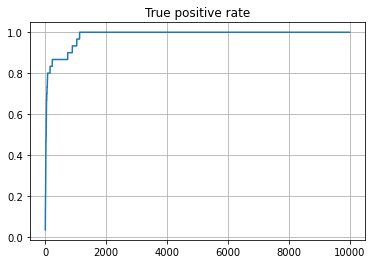

TPR AUC: 0.9841566666666666


In [8]:
# compute true positive rate
tpr = np.cumsum(yf) / np.sum(yf)

import matplotlib.pyplot as plt
plt.plot(tpr)
plt.title('True positive rate')
plt.grid()
plt.show()

print("TPR AUC:", np.average(tpr))

We do the same for the weighted TPR and note that the TPR curve looks better and the AUC value is better.
This shows that anomalies with larger weights are found before those with small weights and this
can only make us happier, because we find earlier the greatest villains.
This was an information that usual TPR doesn't show.

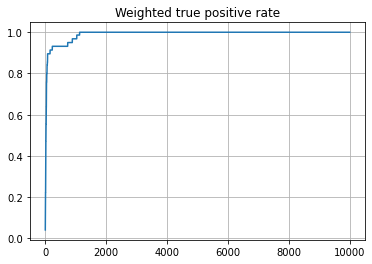

TPR AUC: 0.9907904545454544


In [9]:
yf = labels[iscore,1]  # here we have no alternative method for computing the weighted labels
tpr = np.cumsum(yf) / np.sum(yf)

plt.plot(tpr)
plt.title('Weighted true positive rate')
plt.grid()
plt.show()

print("TPR AUC:", np.average(tpr))